In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras 
import matplotlib
%matplotlib inline

Using TensorFlow backend.


In [2]:
tf.__version__

'1.13.1'

In [3]:
import sys

In [4]:
sys.path.append('../odcd/cd/')

In [5]:
import model_symmetries as vsf

In [6]:
from scipy.stats import entropy

# Data prep

In [450]:
df_white = pd.read_csv('/home/fdz/git/concept_drift_exps/data/wine/winequality_white.csv')

In [451]:
df_white.shape

(4898, 12)

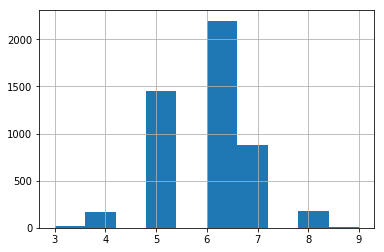

In [452]:
df_white['quality'].hist(bins=10)

In [453]:
df_white['quality'].value_counts() / len(df_white)

6    0.448755
5    0.297468
7    0.179665
8    0.035729
4    0.033279
3    0.004083
9    0.001021
Name: quality, dtype: float64

In [454]:
binary_target = True
if binary_target:
    df_white['target'] = df_white['quality'].apply(lambda x: 0 if x < 6 else 1)
else:
    df_white['target'] = df_white['quality']
df_white.drop('quality', axis=1, inplace=True)
target = 'target'
df_white[target].value_counts() / len(df_white)

1    0.665169
0    0.334831
Name: target, dtype: float64

In [455]:
features = [col for col in df_white.columns if col != target]

In [456]:
X, y = df_white[features].values, df_white[target].values

In [457]:
from sklearn.model_selection import train_test_split

In [458]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [459]:
from sklearn.preprocessing import MinMaxScaler

In [460]:
scale = True
if scale:
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

In [461]:
freq = (df_white[target].value_counts() / len(df_white)).values

In [462]:
samples_weights = [1/freq[i] for i in y_train]

In [463]:
samples_weights = np.asarray(samples_weights)

# Logistic regression

In [464]:
from sklearn.linear_model import LogisticRegression

In [465]:
lg = LogisticRegression()
lg.fit(X_train, y_train)

/home/fdz/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [466]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [467]:
y_preds_train = lg.predict(X_train)
y_preds_test = lg.predict(X_test)

In [468]:
accuracy_score(y_preds_train, y_train)

0.7451674380615301

In [469]:
confusion_matrix(y_preds_train, y_train)

array([[ 598,  289],
       [ 647, 2139]])

In [470]:
accuracy_score(y_preds_test, y_test)

0.7436734693877551

In [471]:
confusion_matrix(y_preds_test, y_test)

array([[181, 100],
       [214, 730]])

# Gxb

In [472]:
from xgboost import XGBClassifier

In [473]:
xgb = XGBClassifier(max_depth=10, n_estimators=100)

In [474]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=10, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [475]:
y_preds_train = xgb.predict(X_train)
y_preds_test = xgb.predict(X_test)

In [476]:
accuracy_score(y_preds_train, y_train)

0.9986387149469099

In [477]:
confusion_matrix(y_preds_train, y_train)

array([[1240,    0],
       [   5, 2428]])

In [478]:
accuracy_score(y_preds_test, y_test)

0.8122448979591836

In [479]:
confusion_matrix(y_preds_test, y_test)

array([[261,  96],
       [134, 734]])

# NN

In [480]:
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [481]:
y_train = np.delete(y_train, np.where(~y_train.any(axis=0)), axis=1)
y_test = np.delete(y_test, np.where(~y_test.any(axis=0)), axis=1)

In [482]:
def model():
    
    x_in = tf.keras.layers.Input(shape=(11, ))
    x = tf.keras.layers.Dense(100, activation='relu')(x_in)
    #x = tf.keras.layers.Dense(50, activation='relu')(x_in)
    if binary_target:
        out = tf.keras.layers.Dense(2, activation='softmax')(x)
    else:
        out = tf.keras.layers.Dense(7, activation='softmax')(x)
    clf = tf.keras.models.Model(x_in, out)
    clf.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    
    clf.summary()
    return clf

In [483]:
clf = model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 11)                0         
_________________________________________________________________
dense_41 (Dense)             (None, 100)               1200      
_________________________________________________________________
dense_42 (Dense)             (None, 2)                 202       
Total params: 1,402
Trainable params: 1,402
Non-trainable params: 0
_________________________________________________________________


In [484]:
np.where(~y_test.any(axis=0))

(array([], dtype=int64),)

In [485]:
print(y_train.shape, y_test.shape)

(3673, 2) (1225, 2)


In [486]:
samples_weights

array([1.5033763 , 2.98658537, 1.5033763 , ..., 2.98658537, 2.98658537,
       1.5033763 ])

In [487]:
clf.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Train on 3673 samples, validate on 1225 samples
Epoch 1/100
3673/3673 [==============================] - 1s 141us/sample - loss: 0.6104 - acc: 0.6515 - val_loss: 0.5643 - val_acc: 0.6824
Epoch 2/100
3673/3673 [==============================] - 0s 41us/sample - loss: 0.5571 - acc: 0.6978 - val_loss: 0.5348 - val_acc: 0.7102
Epoch 3/100
3673/3673 [==============================] - 0s 40us/sample - loss: 0.5300 - acc: 0.7283 - val_loss: 0.5179 - val_acc: 0.7437
Epoch 4/100
3673/3673 [==============================] - 0s 38us/sample - loss: 0.5150 - acc: 0.7395 - val_loss: 0.5152 - val_acc: 0.7445
Epoch 5/100
3673/3673 [==============================] - 0s 40us/sample - loss: 0.5085 - acc: 0.7490 - val_loss: 0.5098 - val_acc: 0.7445
Epoch 6/100
3673/3673 [==============================] - 0s 39us/sample - loss: 0.5042 - acc: 0.7531 - val_loss: 0.5081 - val_acc: 0.7527
Epoch 7/100
3673/3673 [==============================] - 0s 39us/sample - loss: 0.5016 - acc: 0.7522 - val_loss: 0.5075 - v

In [488]:
y_preds_train = clf.predict(X_train)
y_preds_test = clf.predict(X_test)

In [489]:
y_train, y_test = np.argmax(y_train, axis=1), np.argmax(y_test, axis=1)
y_preds_train, y_preds_test = np.argmax(y_preds_train, axis=1), np.argmax(y_preds_test, axis=1)

In [490]:
accuracy_score(y_preds_train, y_train)

0.7862782466648516

In [491]:
confusion_matrix(y_preds_train, y_train)

array([[ 746,  286],
       [ 499, 2142]])

In [492]:
accuracy_score(y_preds_test, y_test)

0.7616326530612245

In [493]:
confusion_matrix(y_preds_test, y_test)

array([[209, 106],
       [186, 724]])

# Symmetry finder test

### Data prep red

In [494]:
df_red = pd.read_csv('/home/fdz/git/concept_drift_exps/data/wine/winequality_red.csv')

In [495]:
df_red.shape

(1599, 12)

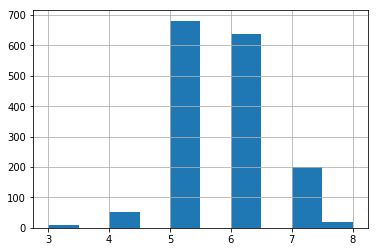

In [496]:
df_red['quality'].hist(bins=10)

In [497]:
df_red['quality'].value_counts() / len(df_red)

5    0.425891
6    0.398999
7    0.124453
4    0.033146
8    0.011257
3    0.006254
Name: quality, dtype: float64

In [498]:
if binary_target:
    df_red['target'] = df_red['quality'].apply(lambda x: 0 if x < 6 else 1)
else:
    df_red['target'] = df_red['quality']
df_red.drop('quality', axis=1, inplace=True)
target = 'target'
df_red[target].value_counts() / len(df_red)

1    0.534709
0    0.465291
Name: target, dtype: float64

In [499]:
features = [col for col in df_red.columns if col != target]

In [500]:
X_red, y_red = df_red[features].values, df_red[target].values

In [501]:
if scale:
    X_red = scaler.transform(X_red)

In [502]:
y_preds_red  = clf.predict(X_red)

In [503]:
y_preds_red = np.argmax(y_preds_red, axis=1)

In [504]:
accuracy_score(y_preds_red, y_red)

0.5028142589118199

In [505]:
confusion_matrix(y_preds_red, y_red)

array([[733, 784],
       [ 11,  71]])

In [506]:
from sklearn.metrics import precision_score, recall_score

In [507]:
precision_score(y_preds_test, y_test)

0.8722891566265061

In [508]:
precision_score(y_preds_red, y_red)

0.08304093567251462

In [509]:
recall_score(y_preds_test, y_test)

0.7956043956043956

In [510]:
recall_score(y_preds_red, y_red)

0.8658536585365854

### find symmetries

In [511]:
window = 1000

In [512]:
def sample_window(X_test, y_test, window):
    samples_rnd = np.random.choice(range(len(X_test)), window, replace=False)
    X_test_samples = X_test[samples_rnd, :]
    y_test_samples = y_test[samples_rnd]
    return X_test_samples, y_test_samples

In [513]:
from importlib import reload

In [514]:
reload(vsf)

<module 'model_symmetries' from '../odcd/cd/model_symmetries.py'>

In [515]:
tf.__version__

'1.13.1'

In [516]:
vae = vsf.VaeSymmetryFinder(clf, input_shape=(11,), output_shape=(2, ), intermediate_dim=512)

Vae
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 11)           0                                            
__________________________________________________________________________________________________
reshape_11 (Reshape)            (None, 11)           0           encoder_input[0][0]              
__________________________________________________________________________________________________
dense_43 (Dense)                (None, 512)          6144        reshape_11[0][0]                 
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense_43[0][0]                   
__________________________________________________________________________________________________
z_log_

In [517]:
vae.fit(X_train, x_test=X_test, epochs=200)

Train on 3673 samples, validate on 1225 samples
Epoch 1/200
3673/3673 [==============================] - 1s 385us/sample - loss: 0.1978 - val_loss: 0.1792
Epoch 2/200
3673/3673 [==============================] - 0s 24us/sample - loss: 0.1797 - val_loss: 0.1665
Epoch 3/200
3673/3673 [==============================] - 0s 23us/sample - loss: 0.1378 - val_loss: 0.0886
Epoch 4/200
3673/3673 [==============================] - 0s 23us/sample - loss: 0.0646 - val_loss: 0.0483
Epoch 5/200
3673/3673 [==============================] - 0s 24us/sample - loss: 0.0436 - val_loss: 0.0392
Epoch 6/200
3673/3673 [==============================] - 0s 24us/sample - loss: 0.0386 - val_loss: 0.0381
Epoch 7/200
3673/3673 [==============================] - 0s 25us/sample - loss: 0.0352 - val_loss: 0.0334
Epoch 8/200
3673/3673 [==============================] - 0s 23us/sample - loss: 0.0329 - val_loss: 0.0353
Epoch 9/200
3673/3673 [==============================] - 0s 24us/sample - loss: 0.0310 - val_loss: 0.02

Epoch 75/200
3673/3673 [==============================] - 0s 25us/sample - loss: 5.5868e-04 - val_loss: 4.4427e-04
Epoch 76/200
3673/3673 [==============================] - 0s 29us/sample - loss: 4.1710e-04 - val_loss: 4.5405e-04
Epoch 77/200
3673/3673 [==============================] - 0s 25us/sample - loss: 3.9598e-04 - val_loss: 4.7406e-04
Epoch 78/200
3673/3673 [==============================] - 0s 28us/sample - loss: 4.4303e-04 - val_loss: 5.0427e-04
Epoch 79/200
3673/3673 [==============================] - 0s 33us/sample - loss: 5.1915e-04 - val_loss: 7.9612e-04
Epoch 80/200
3673/3673 [==============================] - 0s 29us/sample - loss: 5.0608e-04 - val_loss: 4.9290e-04
Epoch 81/200
3673/3673 [==============================] - 0s 25us/sample - loss: 4.4112e-04 - val_loss: 4.1693e-04
Epoch 82/200
3673/3673 [==============================] - 0s 25us/sample - loss: 3.7313e-04 - val_loss: 4.6871e-04
Epoch 83/200
3673/3673 [==============================] - 0s 26us/sample - loss:

3673/3673 [==============================] - 0s 25us/sample - loss: 2.3600e-04 - val_loss: 2.0912e-04
Epoch 147/200
3673/3673 [==============================] - 0s 22us/sample - loss: 1.8311e-04 - val_loss: 5.4429e-04
Epoch 148/200
3673/3673 [==============================] - 0s 27us/sample - loss: 4.1948e-04 - val_loss: 4.5207e-04
Epoch 149/200
3673/3673 [==============================] - 0s 37us/sample - loss: 2.8317e-04 - val_loss: 2.6230e-04
Epoch 150/200
3673/3673 [==============================] - 0s 28us/sample - loss: 2.7482e-04 - val_loss: 2.0157e-04
Epoch 151/200
3673/3673 [==============================] - 0s 26us/sample - loss: 1.9467e-04 - val_loss: 2.5891e-04
Epoch 152/200
3673/3673 [==============================] - 0s 25us/sample - loss: 1.8460e-04 - val_loss: 1.9147e-04
Epoch 153/200
3673/3673 [==============================] - 0s 26us/sample - loss: 1.4155e-04 - val_loss: 2.1550e-04
Epoch 154/200
3673/3673 [==============================] - 0s 25us/sample - loss: 1.57

In [518]:
vae_outs_test = vae.vae.predict(X_test)
symm_samples_test = vae_outs_test[0]
orig_preds_test = vae_outs_test[1]
trans_preds_test = vae_outs_test[2]
    
kl_test = entropy(orig_preds_test.T, trans_preds_test.T)
baseline_std_plus = kl_test.mean() + kl_test.std()
baseline_std_minus = kl_test.mean() - kl_test.std()

In [519]:
mean_test = []
std_test = []
accs_test = []
baseline_stds_plus = []
baseline_stds_minus = []

for step in range(100):
    if step < 99:
        x_window, y_window = sample_window(X_test, y_test, window)
        vae_outs_test = vae.vae.predict(x_window)
        symm_samples_test = vae_outs_test[0]
        orig_preds_test = vae_outs_test[1]
        trans_preds_test = vae_outs_test[2]
    
        kl_test = entropy(orig_preds_test.T, trans_preds_test.T)
        mean_test.append(kl_test.mean())
        std_test.append(kl_test.std())
        preds_test = np.argmax(orig_preds_test, axis=1)
        accs_test.append(accuracy_score(preds_test, y_window))
    
        baseline_stds_plus.append(baseline_std_plus)
        baseline_stds_minus.append(baseline_std_minus)
    else:
        for i in range(0, len(X_red), 15):
            x_window, y_window = sample_window(X_test, y_test, window)
            rnd_idxs_red  = np.random.choice(range(len(X_red)), i)
            x_cont_red = X_red[rnd_idxs_red]
            y_cont_red = y_red[rnd_idxs_red]
            print('Number of contaminations: {} '.format(i))
            
            x_test_cont = np.concatenate((x_window, x_cont_red), axis=0)
            y_test_cont = np.concatenate((y_window, y_cont_red), axis=0)
            print(len(x_test_cont))
            vae_outs_test = vae.vae.predict(x_test_cont)
            symm_samples_test = vae_outs_test[0]
            orig_preds_test = vae_outs_test[1]
            trans_preds_test = vae_outs_test[2]
    
            kl_test = entropy(orig_preds_test.T, trans_preds_test.T)
            mean_test.append(kl_test.mean())
            std_test.append(kl_test.std())
            preds_test = np.argmax(orig_preds_test, axis=1)
            accs_test.append(accuracy_score(preds_test, y_test_cont))
            baseline_stds_plus.append(baseline_std_plus)
            baseline_stds_minus.append(baseline_std_minus)

Number of contaminations: 0 
1000
Number of contaminations: 15 
1015
Number of contaminations: 30 
1030
Number of contaminations: 45 
1045
Number of contaminations: 60 
1060
Number of contaminations: 75 
1075
Number of contaminations: 90 
1090
Number of contaminations: 105 
1105
Number of contaminations: 120 
1120
Number of contaminations: 135 
1135
Number of contaminations: 150 
1150
Number of contaminations: 165 
1165
Number of contaminations: 180 
1180
Number of contaminations: 195 
1195
Number of contaminations: 210 
1210
Number of contaminations: 225 
1225
Number of contaminations: 240 
1240
Number of contaminations: 255 
1255
Number of contaminations: 270 
1270
Number of contaminations: 285 
1285
Number of contaminations: 300 
1300
Number of contaminations: 315 
1315
Number of contaminations: 330 
1330
Number of contaminations: 345 
1345
Number of contaminations: 360 
1360
Number of contaminations: 375 
1375
Number of contaminations: 390 
1390
Number of contaminations: 405 
1405


In [520]:
df = pd.DataFrame()
df['accuracy'] = accs_test
df['entropy_mean'] = mean_test
df['entropy_std'] = std_test
df['baseline_std_plus'] = baseline_stds_plus
df['baseline_std_minus'] = baseline_stds_minus

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1f092b52d0>,
      dtype=object)

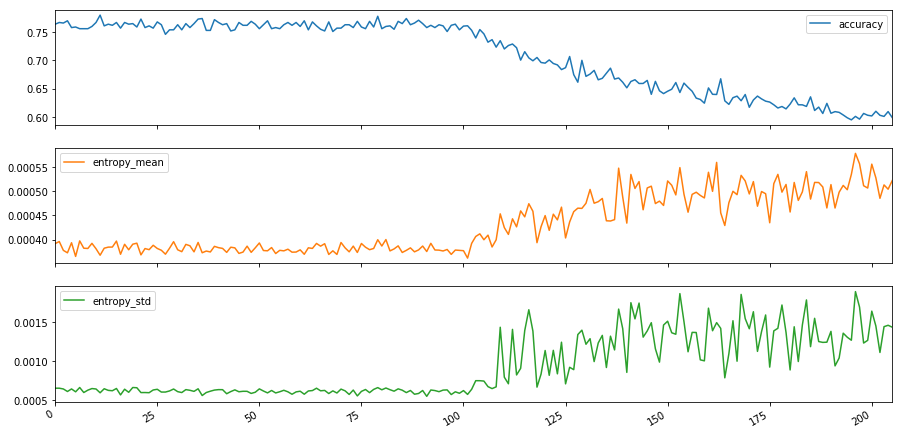

In [521]:
df[['accuracy', 'entropy_mean', 'entropy_std']].plot(logy = False, subplots=True, figsize = (15, 8))

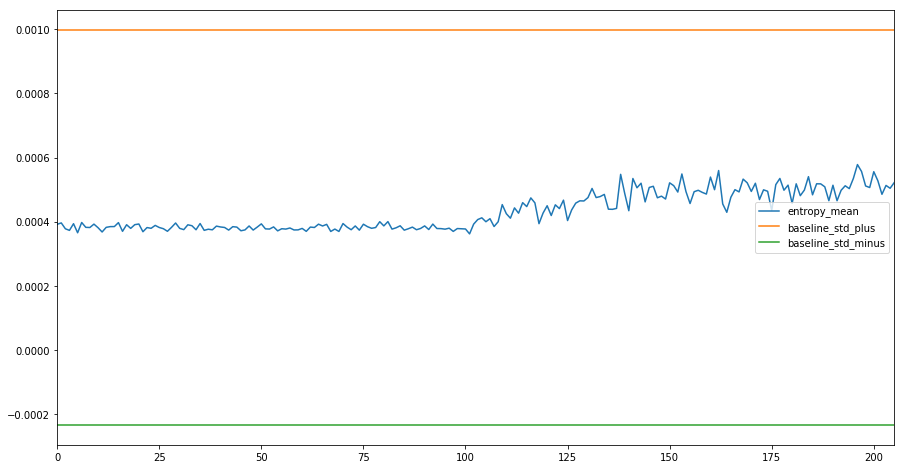

In [522]:
df[['entropy_mean', 'baseline_std_plus', 'baseline_std_minus']].plot(logy = False, subplots=False, figsize = (15, 8))

In [523]:
df.loc[97:107]

,accuracy,entropy_mean,entropy_std,baseline_std_plus,baseline_std_minus
97,0.762000,0.000370,0.000571,0.000998,-0.000234
98,0.764000,0.000379,0.000606,0.000998,-0.000234
99,0.754000,0.000378,0.000587,0.000998,-0.000234
100,0.760591,0.000377,0.000621,0.000998,-0.000234
101,0.761165,0.000362,0.000572,0.000998,-0.000234
102,0.753110,0.000392,0.000638,0.000998,-0.000234
103,0.739623,0.000407,0.000748,0.000998,-0.000234
104,0.754419,0.000412,0.000747,0.000998,-0.000234
105,0.746789,0.000400,0.000743,0.000998,-0.000234
106,0.732127,0.000409,0.000672,0.000998,-0.000234


In [524]:
X_red.shape

(1599, 11)

In [560]:
vae_outs_train = vae.vae.predict(X_train)
vae_outs_test = vae.vae.predict(X_red)

symm_samples_train = vae_outs_train[0]
orig_preds_train = vae_outs_train[1]
trans_preds_train = vae_outs_train[2]

symm_samples_test = vae_outs_test[0]
orig_preds_test = vae_outs_test[1]
trans_preds_test = vae_outs_test[2]

In [561]:
kl_train = entropy(orig_preds_train.T, trans_preds_train.T)
kl_test = entropy(orig_preds_test.T, trans_preds_test.T)

In [562]:
S_train = pd.Series(kl_train, name='train')
S_test = pd.Series(kl_test, name='test')
df_kl = pd.merge(S_train.to_frame(), S_test.to_frame(), right_index=True, left_index=True, how='outer')

0.00031513103749603033 0.0003669103025458753
0.0006002978188917041 0.0017532865749672055


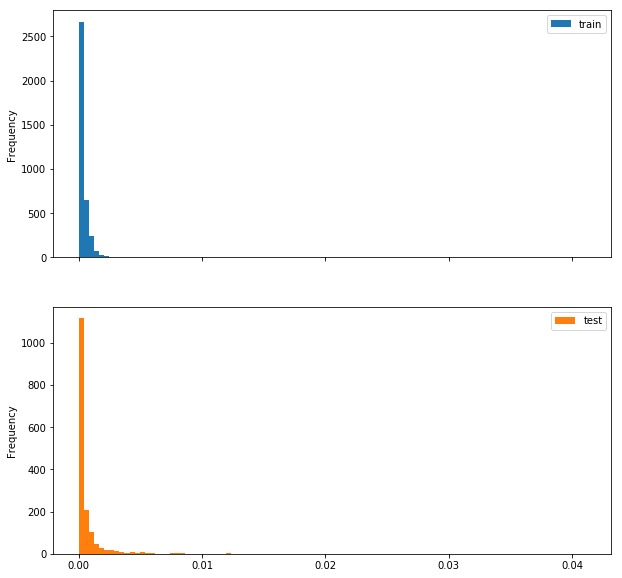

In [563]:
df_kl.plot(kind='hist', bins=100, subplots=True, figsize=(10, 10))
print(S_train.mean(), S_train.std())
print(S_test.mean(), S_test.std())

In [564]:
import matplotlib.pyplot as plt

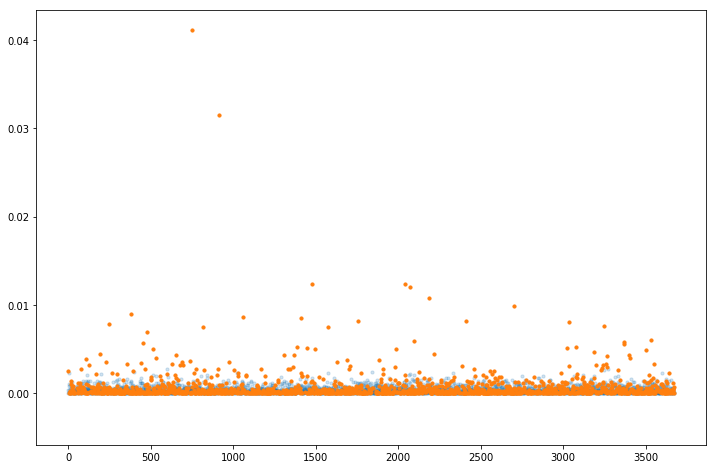

In [565]:
idx_test = np.random.permutation(pd.Series(kl_train).index)[:len(pd.Series(kl_test))]
plt.figure(figsize=(12, 8))
ax1 = plt.scatter(pd.Series(kl_train).index, pd.Series(kl_train), s=10, alpha=0.2)
ax2 = plt.scatter(idx_test, pd.Series(kl_test), s=10, alpha=1)